## Final rescale for paper 1

Since all our scaling is based of the squeezing/stretching of isopyncals and isoconcetration lines near the head, I moved the virtual station DnC to be close to the head (UwH for "upwelling near the head"). The sum of the max stratification above 100 m (rim?) and min stratification below 100 m correlates well with the upwelling flux $\Phi$. So , the stratification, and for that matter tracer gradient, that we want to scale is the one at the head and not at DnC (around mid length). In this notebook I rescale N above, N below, dC/dz above and below and C. 

In [1]:
#import gsw as sw # Gibbs seawater package

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']


In [4]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh= 97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [5]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [6]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,28,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]

for ii in select_rec:
    print(ii,records[ii].label2,records[ii].u_mod)
    

0 base case 0.365
1 $\uparrow$ $K_{bg}$ 0.362
2 $\uparrow \uparrow$ $K_{bg}$ 0.32
3 $\uparrow$ $N_0$ 0.379
4 $\uparrow \uparrow$ $N_0$ 0.397
5 $\Downarrow$ $N_0$ 0.346
51 $\downarrow \downarrow N_0$ 0.348
6 $\downarrow$ $N_0$ 0.354
7 $\uparrow f$ 0.361
8 $\downarrow \downarrow$ $f$ 0.392
9 $\downarrow f$ 0.379
10 $\Downarrow f$ 0.414
17 $\downarrow$ U 0.313
18 $\downarrow \downarrow$ U 0.258
19 $\Downarrow$ U 0.141
20 $\Downarrow$ U, $\downarrow \downarrow$ $N_0$ 0.134
21 $\Downarrow$ U, $\uparrow \uparrow$ $N_0$ 0.151
22 $\Downarrow$ U, $\Downarrow$ $f$ 0.155
23 $\Downarrow$ U, $\uparrow \uparrow K_{can}$ 0.118
24 $K_{can}$ Monterey (bot) 0.342
25 $K_{can}$ Eel (bot) 0.357
26 $K_{can}$ Monterey 0.356
27 $K_{can}$ Ascension (bot) 0.353
28 $K_{can}$ Ascension 0.353
29 $\Uparrow \Uparrow K_{can}$, $\epsilon 10$ 0.347
30 $\Uparrow \Uparrow K_{can}$, $\epsilon 25$ 0.341
31 $\Uparrow \Uparrow K_{can}$, $\epsilon 50$ 0.338
32 $\Uparrow \Uparrow K_{can}$, $\epsilon 100$ 0.338
33 $\Uparrow \Up

In [7]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27,28]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [8]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
   

In [9]:
records_selNoC = []
for ind in select_rec:
    records_selNoC.append(recordsNoC[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                recordsNoC[ind].exp_code,
                                                                                recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    recordsNoC[ind].HCW = dfcan['HCW']
    recordsNoC[ind].HCWTr1 = dfcan['HCWTr1']
    recordsNoC[ind].TrMass = dfcan['TrMassHCW']
    recordsNoC[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    recordsNoC[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    recordsNoC[ind].TrMassTot = dfcan['TotTrMass']
    recordsNoC[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    recordsNoC[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']


In [10]:
keys2 = ['N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
    Nab = np.empty(len(keys2))
    Nbe = np.empty(len(keys2))
    
    for key,ii in zip(keys2, range(len(keys2))):
        Nab[ii] = np.max(df[keys2[ii]][:20]) #0:20
        Nbe[ii] = np.min(df[keys2[ii]][20:23]) #20:24
        
    records[ind].Nab = np.mean(Nab)
    records[ind].Nbe = np.mean(Nbe)
    records[ind].Nab_std = np.std(Nab)
    records[ind].Nbe_std = np.std(Nbe)
        

In [11]:
keys2 = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16','dTrdz_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    dTrab = 0
    dTrbe = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        dTrab = dTrab + np.min(df[keys2[ii]][:20]) #0:20
        dTrbe = dTrbe + np.max(df[keys2[ii]][20:23]) #20:24
    
    records[ind].dTr_ab = dTrab/  len(keys2)
    records[ind].dTr_be = dTrbe/  len(keys2)
    records[ind].dTr0 = df['dTrdz_tt00'][15]

In [12]:
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.zeros(len(keys2))
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab[ii] = np.max(df[keys2[ii]][20:22]) #0:20
        
    records[ind].Tr =  np.nanmean(Nab)
    records[ind].Tr_std = np.std(Nab)
    records[ind].Tr0 = df['Tr_profile_tt00'][20]


## Stratification and upwelling flux

In previous notebooks I found that the upwelling flux is porportional to an effective stratification $N_{eff}$ given by the sum of the maximum stratification above the rim, near the head and the minimum stratification below the rim. 

$$N_{eff} = {0.67N_{max}+0.33N_{min}}$$

So first, we scale $N_{max}$ and $N_{min}$ similarly as we did in the previous version of the paper: we use the squeezing and stretching of isopycnals given by $Z_{dif}$ and we add the effect of the smoothness of the diffusivity profile $\epsilon$.

Once we get both N's, we can scale $N_{eff}$ and use it in the depth scale $D_h$ in the scaling for $\Phi$ by Howatt and Allen as $D_{eff}=fL/N_{eff}$, with proper fitting parameters.

For Nmin: slope = 4.62, intercept = -4.690, r-value = 0.916
For Nmax: slope = 5.94, intercept = -4.423, r-value = 0.779


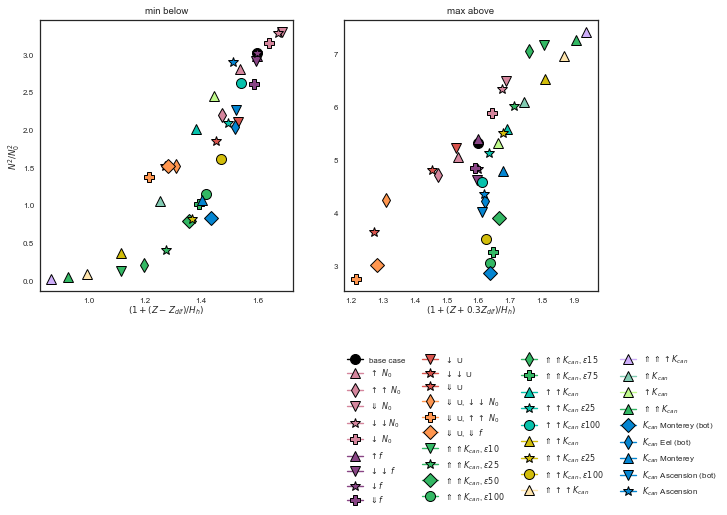

In [79]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    
    #Zdif = np.sqrt(t*3600*24*((rec.kv-rec.kbg)))
    Zdif = Hh**(0.5)*np.sqrt(t*3600*24*((rec.kv-rec.kbg))/rec.epsilon)
    
    rec.Z = Z
    rec.Zdif = Zdif
    
    #plt1 = ax0.plot((1+(Z-Zdif)/Hh),(rec.Nbe)**2/(rec.N**2),
    #                marker = rec.mstyle,
    #                markersize = 10,
    #                color = sns.xkcd_rgb[rec.color2],
    #                markeredgewidth=1.0,
    #                markeredgecolor = 'k',
    #                label=rec.label2)
    #plt1 = ax1.plot(((1+(Z+0.3*Zdif)/Hh)),(rec.Nab)**2/(rec.N**2),
    #                marker = rec.mstyle,
    #                markersize = 10,
    #                color = sns.xkcd_rgb[rec.color2],
    #                markeredgewidth=1.0,
    #                markeredgecolor = 'k',
    #                label=rec.label2)
    plt1 = ax0.plot(1+(Z/Hh)-0.2*(Zdif/Hh),(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(1+(Z/Hh)+0.1*(Zdif/Hh),(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
   

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)
ax1.set_xlabel(r'$(1+(Z+0.3Z_{dif})/H_h)$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')

#Y0_array = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])
#X0_array = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_epsilon])
#slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X0_array,Y0_array)
#print('For Nmin: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope0, intercept0, r_value0))

#Y1_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
#X1_array = np.array([1+(rec.Z+0.3*rec.Zdif)/Hh for rec in records_epsilon])
#slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(X1_array,Y1_array)
#print('For Nmax: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope1, intercept1, r_value1))

Y0_array = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])
X0_array = np.array([1+(rec.Z/Hh)-0.2*(rec.Zdif/Hh) for rec in records_epsilon])
slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X0_array,Y0_array)
print('For Nmin: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope0, intercept0, r_value0))

Y1_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
X1_array = np.array([1+(rec.Z/Hh)+0.1*(rec.Zdif/Hh) for rec in records_epsilon])
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(X1_array,Y1_array)
print('For Nmax: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope1, intercept1, r_value1))


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

We fit a line through the step runs and dynamical runs:

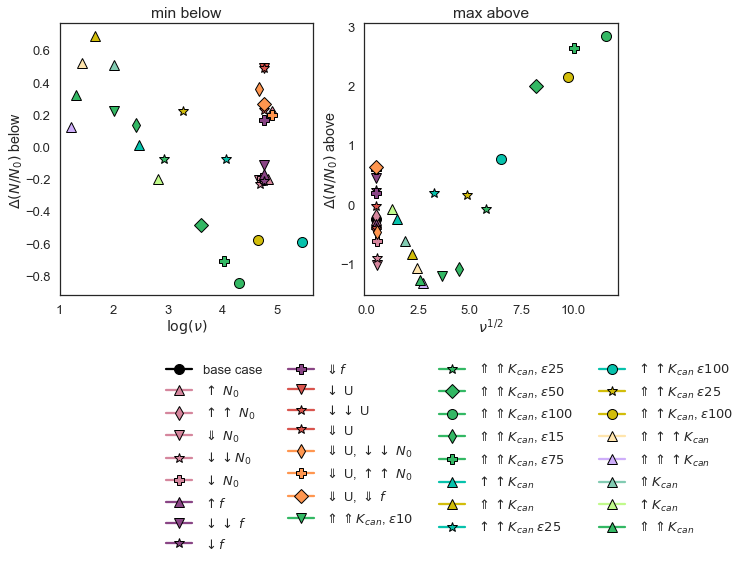

In [14]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:

    plt1 = ax0.plot(np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2))), slope0*(1+(rec.Z-rec.Zdif)/Hh)+intercept0-((rec.Nbe)**2/(rec.N**2)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    
    plt1 = ax1.plot(((rec.epsilon)**2*rec.kv/rec.N)**0.25,slope1*(1+(rec.Z+0.3*rec.Zdif)/Hh)+intercept1-((rec.Nab)**2/(rec.N**2)),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    
    
ax0.set_xlabel(r'$\log(\nu)$',labelpad=0.5)
ax1.set_xlabel(r'$\nu^{1/2}$',labelpad=0.5)
ax0.set_ylabel(r'$\Delta(N/N_0)$ below',labelpad=0.5)
ax1.set_ylabel(r'$\Delta(N/N_0)$ above',labelpad=0.5)

ax1.set_title('max above')
ax0.set_title('min below')

ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [80]:
X2_be = np.array([(rec.Z/Hh) for rec in records_epsilon])
X1_be = np.array([(-0.2*rec.Zdif/Hh) for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X2_ab = np.array([(rec.Z/Hh) for rec in records_epsilon])
X1_ab = np.array([ 0.1*(rec.Zdif/Hh)for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])



In [81]:
from sklearn import linear_model
reg_be = linear_model.LinearRegression()
reg_be.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be.coef_)
print(reg_be.intercept_)

reg_ab = linear_model.LinearRegression()
reg_ab.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab.coef_)
print(reg_ab.intercept_)


[ 4.7107241   4.05413651]
0.24390363366
[ 6.63065554  5.30239699]
1.80733090384


In [77]:
# save values of N_eff and Phi
for rec in records_sel:
   
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    rec.Phi = Phi
    rec.Phi_std = Phi_std

for rec in records_real:

    #rec.Nab_scaled = np.sqrt(reg_ab.coef_[0]*(1+(rec.Z+0.3*rec.Zdif)/Hh)+
    #                 reg_ab.coef_[1]*((rec.epsilon**2)*(rec.kv/rec.N))**0.25+
    #                 reg_ab.intercept_)*rec.N
    #rec.Nbe_scaled = np.sqrt(reg_be.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
    #                 reg_be.coef_[1]*np.log((rec.epsilon)/((rec.kv/rec.N)**(0.5)))+
    #                 reg_be.intercept_)*rec.N
    
    rec.Nab_scaled = np.sqrt(reg_ab.coef_[0]*(rec.Z/Hh)+
                     reg_ab.coef_[1]* (0.1*rec.Zdif/Hh)+
                     reg_ab.intercept_)*rec.N
    rec.Nbe_scaled = np.sqrt(reg_be.coef_[0]*(rec.Z/Hh)-
                     reg_be.coef_[1]* (0.2*rec.Zdif/Hh)+
                     reg_be.intercept_)*rec.N
    
    if  (reg_be.coef_[0]*(rec.Z/Hh)+reg_be.coef_[1]* (rec.Zdif/Hh)+reg_be.intercept_)< 0 :
        rec.N_eff_scaled = (0.67*rec.Nab_scaled)
    else:
        rec.N_eff_scaled =  (0.67*rec.Nab_scaled + 0.33*rec.Nbe_scaled) 
    
    rec.Neff = (0.67*rec.Nab+0.33*rec.Nbe)
    

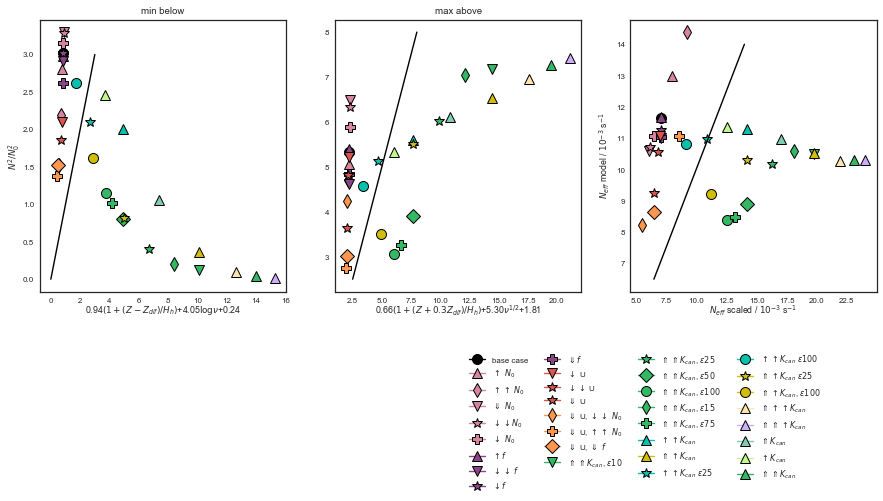

In [78]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (15,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot(rec.Nbe_scaled**2/rec.N**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
      
    plt1 = ax1.plot(rec.Nab_scaled**2/rec.N**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
ax0.plot(np.linspace(0,3,20),np.linspace(0,3,20), 'k-')
ax1.plot(np.linspace(2.5,8,20),np.linspace(2.5,8,20), 'k-')

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_be.coef_[0], reg_be.coef_[1], reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+0.3Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_ab.coef_[0], reg_ab.coef_[1], reg_ab.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')

for rec in records_epsilon:
    plt1 = ax2.plot(rec.N_eff_scaled/1E-3,(rec.Neff)/1E-3,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
ax2.plot(np.linspace(0.0065, 0.014, 20)/1E-3,np.linspace(0.0065, 0.014, 20)/1E-3,'k-')
ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$')
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.1)
ax1.legend(bbox_to_anchor=(2,-0.2), ncol=4)



In [19]:
# records_epsilon has all runs in dyn, step and the ones where epsilon changes.

for param in np.linspace(0.6, 1.5, 60):
    for rec in records_real:
        Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
        rec.X = (F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3)

        rec.Phi_nonDim = rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))
        
    Y_array = np.array([rec.Phi_nonDim for rec in records_epsilon])
    X_array = np.array([rec.X for rec in records_epsilon])

    slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope2, intercept2, r_value2))

Using parameter 0.60: slope = 4.21, intercept = -0.046, r-value = 0.840
Using parameter 0.62: slope = 4.37, intercept = -0.049, r-value = 0.849
Using parameter 0.63: slope = 4.53, intercept = -0.052, r-value = 0.859
Using parameter 0.65: slope = 4.69, intercept = -0.055, r-value = 0.868
Using parameter 0.66: slope = 4.86, intercept = -0.058, r-value = 0.876
Using parameter 0.68: slope = 5.02, intercept = -0.060, r-value = 0.884
Using parameter 0.69: slope = 5.19, intercept = -0.062, r-value = 0.892
Using parameter 0.71: slope = 5.36, intercept = -0.064, r-value = 0.900
Using parameter 0.72: slope = 5.52, intercept = -0.066, r-value = 0.907
Using parameter 0.74: slope = 5.69, intercept = -0.067, r-value = 0.913
Using parameter 0.75: slope = 5.86, intercept = -0.068, r-value = 0.919
Using parameter 0.77: slope = 6.03, intercept = -0.069, r-value = 0.925
Using parameter 0.78: slope = 6.19, intercept = -0.069, r-value = 0.930
Using parameter 0.80: slope = 6.36, intercept = -0.069, r-value 

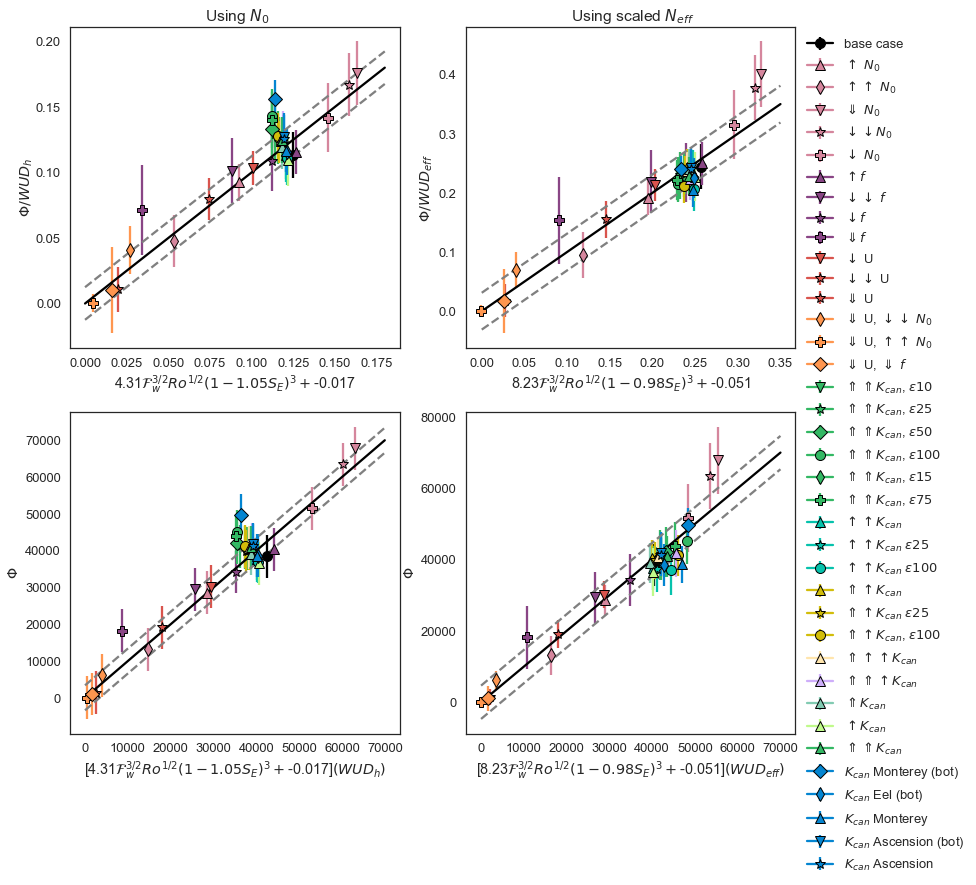

In [20]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (13,13)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])


slope = 4.31
param = 1.05
intercept = -0.017

slope2 = 8.23
param2 = 0.98
intercept2 = -0.051

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018=((slope2*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param2*Se)**3))+intercept2)
    
    rec.HA2013 = HA2013
    rec.HA2013_sqe = (rec.Phi-rec.HA2013)**2
    
    rec.RA2018 = RA2018
    rec.RA2018_sqe = (rec.Phi-rec.RA2018)**2
    
    plt1 = ax0.errorbar(rec.HA2013,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N)),
                        yerr=rec.Phi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N)),
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.RA2018,rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),
                        yerr=rec.Phi_std/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax2.errorbar(rec.HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N)),rec.Phi,
                        yerr=Phi_std,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax3.errorbar(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)),rec.Phi,
                        yerr=rec.Phi_std,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
# MSE ax0    
phi_array = np.array([rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N)) for rec in records_dyn])
sca_array = np.array([rec.HA2013 for rec in records_dyn])
x_fit = np.linspace(0,0.18, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)) for rec in records_dyn])
sca_array = np.array([rec.RA2018 for rec in records_dyn])
x_fit = np.linspace(0,0.35, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

    
# MSE ax2    
phi_array = np.array([rec.Phi for rec in records_dyn])
sca_array = np.array([rec.HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N)) for rec in records_dyn])
x_fit = np.linspace(0,70000, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.array([rec.Phi for rec in records_dyn])
sca_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled)) for rec in records_dyn])
x_fit = np.linspace(0,70000, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

xx0 = np.linspace(0,0.18,50)   
ax0.plot(xx0,xx0,'k-')
ax1.plot(np.linspace(0,0.35,50),np.linspace(0,0.35,50),'k-')

xx1 = np.linspace(0,70000,50)   
ax2.plot(xx1,xx1,'k-')
ax3.plot(xx1,xx1,'k-')

ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi/WUD_h$')
ax1.set_ylabel('$\Phi/WUD_{eff}$')
ax2.set_ylabel('$\Phi$')
ax3.set_ylabel('$\Phi$')

ax0.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope,param, intercept))
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope2,param2, intercept2))
ax2.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_h)$' %(slope,param, intercept))
ax3.set_xlabel(r'[%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f]$(WUD_{eff})$' %(slope2,param2, intercept2))

ax0.set_title(' Using $N_0$')
ax1.set_title(' Using scaled $N_{eff}$')

ax1.legend(bbox_to_anchor=(1,1), ncol=1)


## Tracer gradient, concentration and upwelling tracer flux

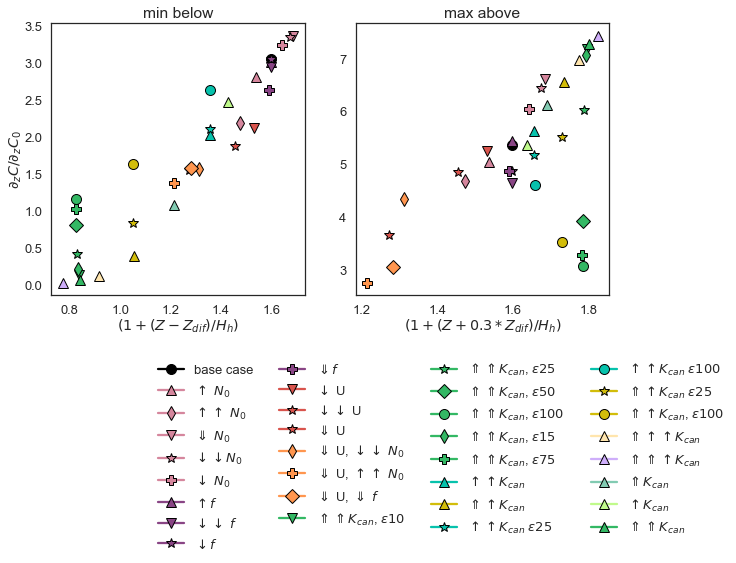

In [21]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% tracer gradient %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    
    plt1 = ax0.plot((1+(rec.Z-rec.Zdif)/Hh),(rec.dTr_be)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot((1+(rec.Z+0.3*rec.Zdif)/Hh),(rec.dTr_ab)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
   

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)
ax1.set_xlabel(r'$(1+(Z+0.3*Z_{dif})/H_h)$',labelpad=0.5)

ax0.set_title('min below')
ax1.set_title('max above')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

In [22]:
X2_be = np.array([np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2))) for rec in records_epsilon])
X1_be = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X2_ab = np.array([((rec.epsilon**2)*(rec.kv/rec.N))**0.25 for rec in records_epsilon])
X1_ab = np.array([1+(rec.Z+0.3*rec.Zdif)/Hh for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])



In [23]:
from sklearn import linear_model
reg_be_dTr = linear_model.LinearRegression()
reg_be_dTr.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(reg_be_dTr.coef_)
print(reg_be_dTr.intercept_)

reg_ab_dTr = linear_model.LinearRegression()
reg_ab_dTr.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(reg_ab_dTr.coef_)
print(reg_ab_dTr.intercept_)


[ 2.65260541  0.2082942 ]
-2.42595517286
[ 8.33127814 -0.34995495]
-7.40176319035


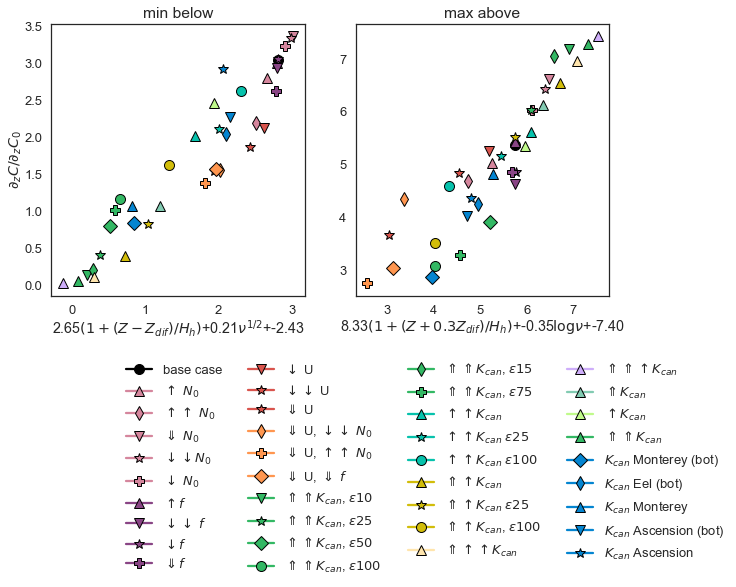

In [24]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer gradient %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot((reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                     reg_be_dTr.coef_[1]*np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2)))+
                     reg_be_dTr.intercept_),(rec.dTr_be)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    rec.X1_be = np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2)))
    rec.X2_be = 1+(rec.Z-rec.Zdif)/Hh
    
    plt1 = ax1.plot((reg_ab_dTr.coef_[0]*(1+(rec.Z+0.4*rec.Zdif)/Hh)+
                     reg_ab_dTr.coef_[1]*((rec.epsilon**2)*(rec.kv/rec.N))**0.25+
                     reg_ab_dTr.intercept_),(rec.dTr_ab)/(rec.dTr0),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    rec.X1_ab = ((rec.epsilon**2)*(rec.kv/rec.N))**0.25
    rec.X2_ab = 1+(rec.Z+0.3*rec.Zdif)/Hh
    
#ax0.plot(np.linspace(0,1.5,20),np.linspace(0,1.5,20), 'k-')
#ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be_dTr.coef_[0], reg_be_dTr.coef_[1], reg_be_dTr.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+0.3Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab_dTr.coef_[0], reg_ab_dTr.coef_[1], reg_ab_dTr.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [25]:
# save values of dTr scaled
for rec in records_sel:
    
    can_eff = rec.TrMass
    Phi_Tr = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    Phi_Tr_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    
    rec.PhiTr = Phi_Tr
    rec.PhiTr_std = Phi_Tr_std

for rec in records_real:
    
    rec.dTr_ab_scaled = (reg_ab_dTr.coef_[0]*(1+(rec.Z+0.3*rec.Zdif)/Hh)+
                        reg_ab_dTr.coef_[1]*((rec.epsilon**2)*(rec.kv/rec.N))**0.25+
                        reg_ab_dTr.intercept_)*rec.dTr0
    rec.dTr_be_scaled = (reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
                        reg_be_dTr.coef_[1]*np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2)))+
                        reg_be_dTr.intercept_)*rec.dTr0
    
    if  (reg_be_dTr.coef_[0]*(1+(rec.Z-rec.Zdif)/Hh)+
        reg_be_dTr.coef_[1]*np.log((rec.epsilon)/((rec.kv/rec.N)**(1/2)))+
        reg_be_dTr.intercept_)< 0 :
        rec.dTr_eff_scaled = (rec.dTr_ab_scaled)/2
    else:
        rec.dTr_eff_scaled =  (rec.dTr_ab_scaled + rec.dTr_be_scaled) /2

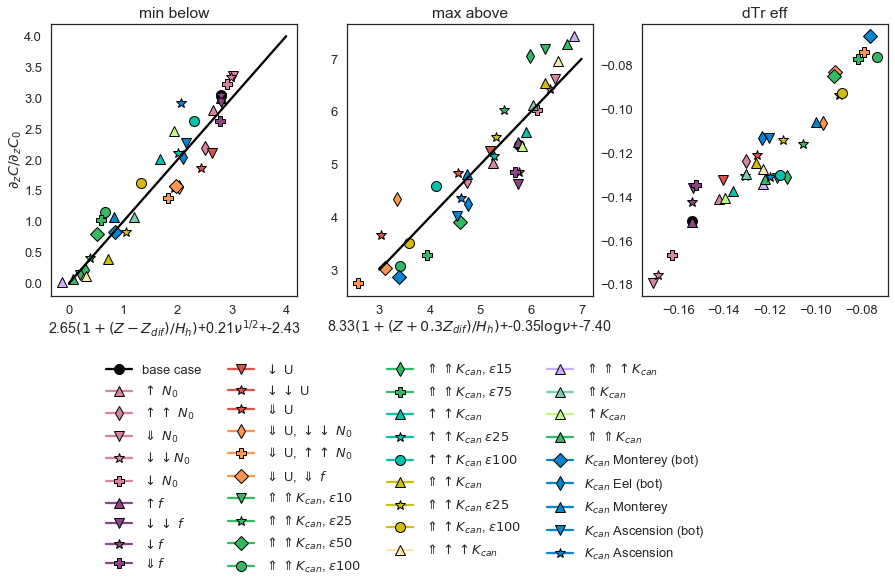

In [26]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (15,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
    
    plt1 = ax0.plot(rec.dTr_be_scaled/rec.dTr0,(rec.dTr_be)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
   
    plt1 = ax1.plot(rec.dTr_ab_scaled/rec.dTr0,(rec.dTr_ab)/(rec.dTr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    
    plt2 = ax2.plot(rec.dTr_eff_scaled,(rec.dTr_ab + rec.dTr_be) /2,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    
ax0.plot(np.linspace(0,4,20),np.linspace(0,4,20), 'k-')
ax1.plot(np.linspace(3,7,20),np.linspace(3,7,20), 'k-')

ax0.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f$\nu^{1/2}$+%1.2f' %(reg_be_dTr.coef_[0], reg_be_dTr.coef_[1], reg_be_dTr.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z+0.3Z_{dif})/H_h)$+%1.2f$\log{\nu}$+%1.2f' %(reg_ab_dTr.coef_[0], reg_ab_dTr.coef_[1], reg_ab_dTr.intercept_)
               ,labelpad=0.5)


ax1.set_title('max above')
ax0.set_title('min below')
ax2.set_title('dTr eff')


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

### Concentration

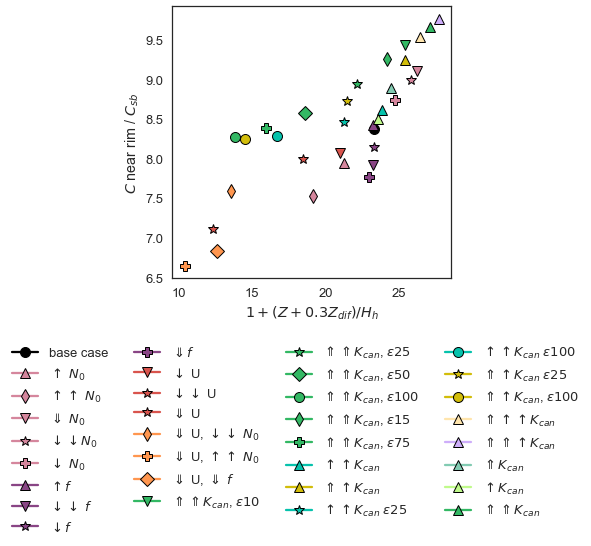

In [27]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    plt1 = ax0.plot((rec.dTr_ab_scaled*(RC[20]+RC[24])/2),rec.Tr,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
ax0.set_ylabel('$C$ near rim / $C_{sb}$')
ax0.set_xlabel(r'$1+(Z+0.3Z_{dif})/H_h$')


ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


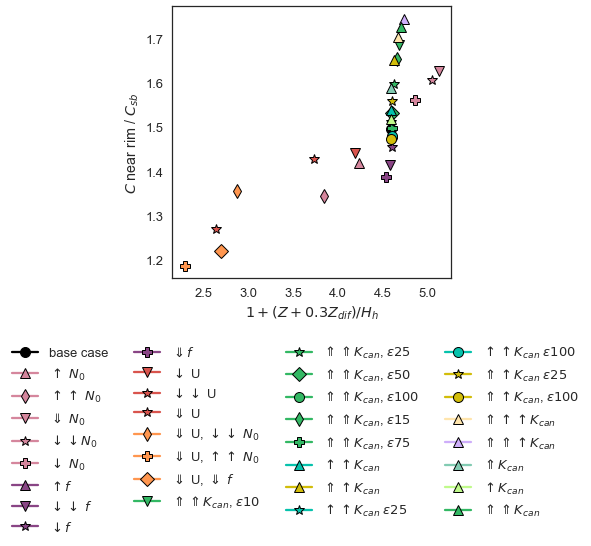

In [28]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
    plt1 = ax0.plot((1+(6*rec.Z+0.3*rec.Zdif)/Hh),rec.Tr/rec.Tr0,
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
ax0.set_ylabel('$C$ near rim / $C_{sb}$')
ax0.set_xlabel(r'$1+(Z+0.3Z_{dif})/H_h$')


ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)


In [29]:
X_simple = np.array([1+(6*rec.Z+0.3*rec.Zdif)/Hh for rec in records_step])
Y_C = np.array([rec.Tr/rec.Tr0 for rec in records_step])

reg_Csimple = linear_model.LinearRegression()
reg_Csimple.fit (np.transpose([X_simple]),np.transpose(Y_C) )
print(reg_Csimple.coef_)
print(reg_Csimple.intercept_)



[ 0.15611017]
0.828448469588


Text(0,0.5,'$C$ near rim / $C_{sb}$')

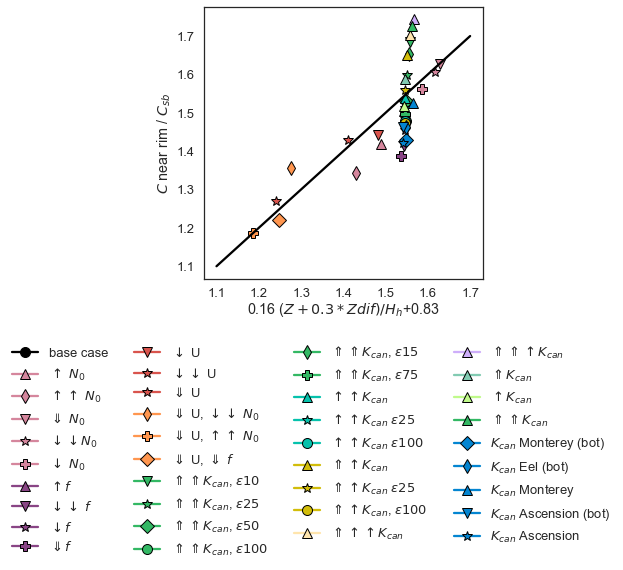

In [30]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  
    plt1 = ax0.plot((reg_Csimple.coef_*(1+(6*rec.Z+0.3*rec.Zdif)/Hh)+  
                    reg_Csimple.intercept_),
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    rec.Tr_scaled_simple = (reg_Csimple.coef_*(1+(6*rec.Z+0.3*rec.Zdif)/Hh)+  
                           reg_Csimple.intercept_)*rec.Tr0
ax0.plot(np.linspace(1.1,1.7,20),np.linspace(1.1,1.7,20),'k-')       
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'%1.2f ($Z+0.3*Zdif)/H_h$+%1.2f' %(reg_Csimple.coef_,reg_Csimple.intercept_),labelpad=0.5)
ax0.set_ylabel(r'$C$ near rim / $C_{sb}$')

Text(0,0.5,'C scaled - C model')

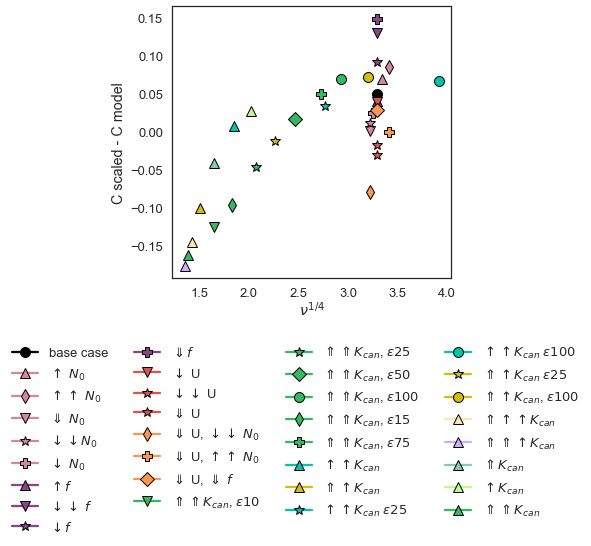

In [31]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_epsilon:
  
    plt1 = ax0.plot((rec.epsilon/(rec.kv/rec.N)**0.5)**0.25,(reg_Csimple.coef_*(1+(6*rec.Z+0.3*rec.Zdif)/Hh)+  
                    reg_Csimple.intercept_)-(rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'$\nu^{1/4}$' ,labelpad=0.5)
ax0.set_ylabel(r'C scaled - C model')

In [32]:
X1_C = np.array([1+(6*rec.Z+0.3*rec.Zdif)/Hh for rec in records_epsilon])
X2_C = np.array([(rec.epsilon/(rec.kv/rec.N)**0.5)**0.25 for rec in records_epsilon])
Y_C = np.array([rec.Tr/rec.Tr0 for rec in records_epsilon])

reg_C = linear_model.LinearRegression()
reg_C.fit (np.transpose([X1_C,X2_C]),np.transpose(Y_C) )
print(reg_C.coef_)
print(reg_C.intercept_)

[ 0.12017726 -0.09299643]
1.23627867988


Text(0,0.5,'$C$ at rim depth / $C_{0}$')

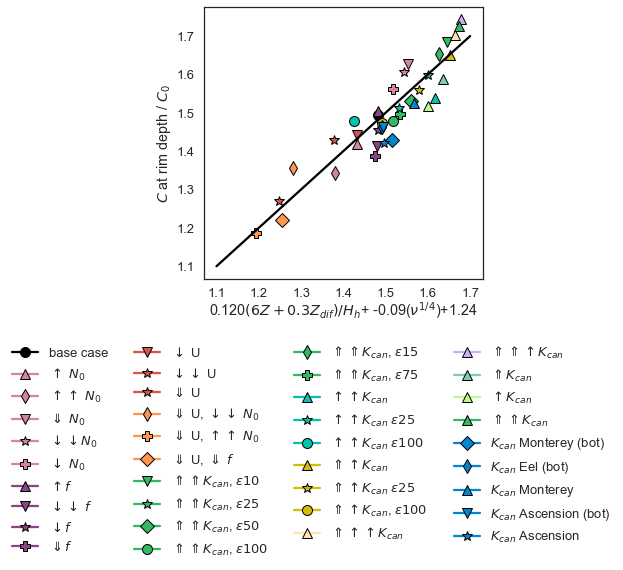

In [33]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concentration at rim %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  
    plt1 = ax0.plot((reg_C.coef_[0]*(1+(6*rec.Z+0.3*rec.Zdif)/Hh)+
                    reg_C.coef_[1]*((rec.epsilon/(rec.kv/rec.N)**0.5)**0.25)+  
                    reg_C.intercept_),
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 10,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=1.0,
                     markeredgecolor = 'k',
                     label=rec.label2)
    rec.Tr_scaled = (reg_C.coef_[0]*(1+(6*rec.Z+0.3*rec.Zdif)/Hh)+
                    reg_C.coef_[1]*((rec.epsilon/(rec.kv/rec.N)**0.5)**0.25)+  
                    reg_C.intercept_)*rec.Tr0
ax0.plot(np.linspace(1.1,1.7,20),np.linspace(1.1,1.7,20),'k-')       
ax0.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

ax0.set_xlabel(r'%1.3f$(6Z+0.3Z_{dif})/H_h$+ %1.2f($\nu^{1/4}$)+%1.2f' %(reg_C.coef_[0],reg_C.coef_[1],reg_C.intercept_),labelpad=0.5)
ax0.set_ylabel(r'$C$ at rim depth / $C_{0}$')

(0, 6)

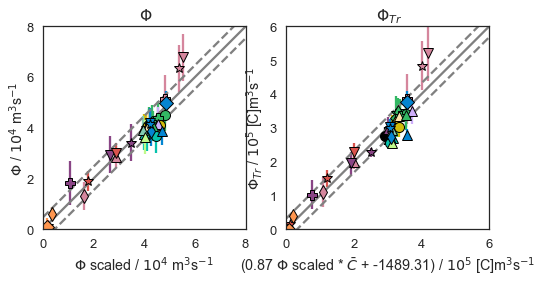

In [34]:
plt.rcParams['font.size'] = 8.0

fig,(ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))

ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
ax1.plot(np.linspace(0,6,50),np.linspace(0,6,50),'-', color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  

    Y_array = np.array([rec.PhiTr for rec in records_epsilon])
    X_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled) for rec in records_epsilon])

    slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),Y_array)

    rec.PhiTr_scaled = (slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)
    
    plt1 = ax0.errorbar(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4,rec.Phi/1E4,yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar((slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=1.0,
                        markeredgecolor = 'k',
                        label=rec.label2)

# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('$\Phi$ / $10^4$ m$^3$s$^{-1}$')
ax1.set_ylabel('$\Phi_{Tr}$ / $10^5$ [C]m$^3$s$^{-1}$')

ax0.set_xlabel(r'$\Phi$ scaled / $10^4$ m$^3$s$^{-1}$' )
ax1.set_xlabel(r'(%1.2f $\Phi$ scaled * $\bar{C}$ + %1.2f) / $10^5$ [C]m$^3$s$^{-1}$' %(slope6, intercept6))

ax0.set_title(' $\Phi$')
ax1.set_title(' $\Phi_{Tr}$')

ax0.set_aspect(1)
ax1.set_aspect(1)
ax0.set_xlim(0,8)
ax0.set_ylim(0,8)
ax1.set_xlim(0,6)
ax1.set_ylim(0,6)


In [35]:
BAC_array = np.array( [ 10.51325415,   7.04127235,   3.98023107,  17.10060821,
                        16.11140949,  13.85213877,  11.05337763,   7.45709706,
                         8.86285309,   5.65066655,   8.86225387,   6.00296182,
                         1.2629518 ,   2.56032869,   0.3393471 ,   0.80551852,
                        18.04660234,  15.68697396,  11.99783917,   9.06529572,
                        17.51985767,  10.00787355,   8.11634524,  12.70847682,
                        11.95856312,  10.69285533,  16.37336583,  14.14683837,
                         9.92706316,  17.7683478 ,  18.73067473,  14.50473729,
                        11.81661951,  18.35687705,   9.23065985,  10.46856391,
                        12.61419497,  11.21805623,  11.79427934])

Area_array =   [46.5491335754,
                38.2917934328,
                26.9448332095,
                56.3817703596,
                55.182684103,
                51.9903642063,
                47.8059790456,
                37.6237425458,
                42.0910214116,
                30.7664212385,
                40.8465914993,
                32.9580624808,
                7.68000144345,
                13.6185030516,
                0.415876594776,
                2.16785064766,
                63.1188268131,
                63.1616737274,
                57.8566896409,
                46.9466246469,
                63.5691961993,
                52.4247201538,
                37.7064332802,
                51.2272862284,
                50.1747159478,
                48.4492795904,
                58.4347067957,
                57.1715659942,
                50.5199063321,
                60.9728115171,
                62.4251483425,
                54.6991068101,
                49.2334222265,
                62.0793817652,
                51.4493454317,
                49.1100729942,
                51.1891636369,
                50.6646476173,
                51.3909571846,
                ]
for rec,bac,area in zip(records_real, BAC_array, Area_array):
    rec.BAC = bac
    rec.Area = area

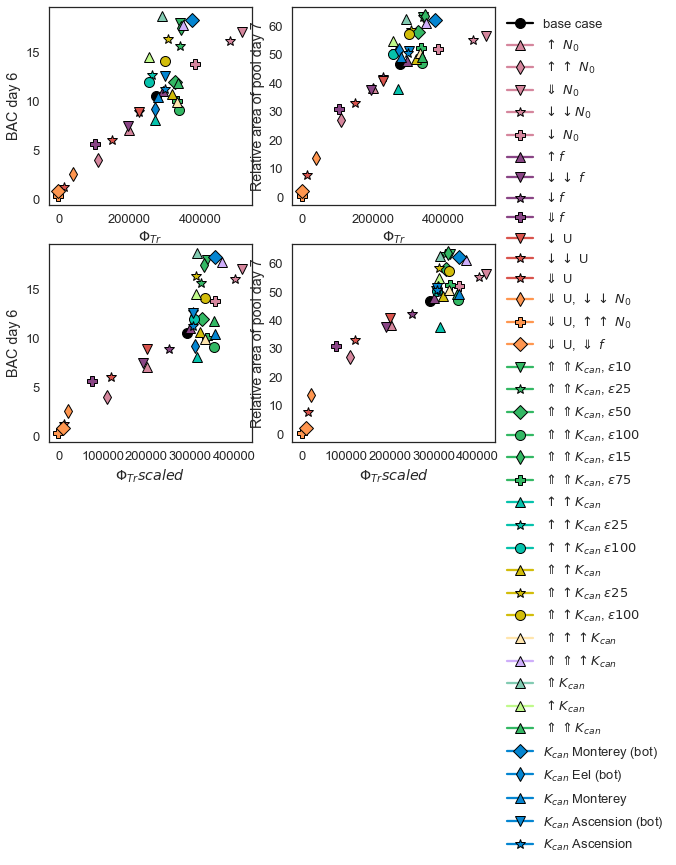

In [36]:
plt.rcParams['font.size'] = 8.0

fig,((ax0, ax1), (ax2,ax3)) = plt.subplots(2, 2, figsize=(8,8))

#ax0.plot(np.linspace(0,8,50),np.linspace(0,8,50),'-', color='0.5')
#ax1.plot(np.linspace(0,6,50),np.linspace(0,6,50),'-', color='0.5')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_real:
  

    Y_array = np.array([rec.PhiTr_scaled for rec in records_epsilon])
    X_array = np.array([rec.BAC for rec in records_epsilon])

    slope7, intercept7, r_value7, p_value7, std_err7 = scipy.stats.linregress(np.squeeze(X_array),Y_array)

   
    plt1 = ax0.plot(rec.PhiTr,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(rec.PhiTr, rec.Area,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax2.plot(rec.PhiTr_scaled,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax3.plot(rec.PhiTr_scaled, rec.Area,
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label2)


# MSE ax1    
#phi_array = np.array([slope7*rec.PhiTr_scaled+intercept7 for rec in records_epsilon])
#sca_array = np.array([rec.BAC for rec in records_epsilon])
#x_fit = np.linspace(0,6, 50)
#mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
#upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
#lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

ax0.set_xlabel('$\Phi_{Tr}$')
ax1.set_xlabel('$\Phi_{Tr}$')

ax2.set_xlabel('$\Phi_{Tr} scaled$')
ax3.set_xlabel('$\Phi_{Tr} scaled$')

ax0.set_ylabel('BAC day 6')
ax2.set_ylabel('BAC day 6')

ax1.set_ylabel('Relative area of pool day 7')
ax3.set_ylabel('Relative area of pool day 7')

ax1.legend(bbox_to_anchor=(1,1))



## Paper Figures

### Figure (num)

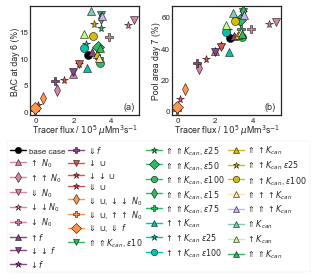

In [37]:
sns.set_context('paper')
plt.rcParams['font.size'] = 9.0
f = plt.figure(figsize = (4.5,2)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2, wspace=0.3)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])


for rec in records_real[:-5]:
  
    plt1 = ax0.plot(rec.PhiTr/1E5,rec.BAC,
                    marker = rec.mstyle,
                    markersize = 8,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt1 = ax1.plot(rec.PhiTr/1E5, rec.Area,
                    marker = rec.mstyle,
                    markersize = 8,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
   

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax1.set_xlabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)
ax0.set_xlabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_ylabel('BAC at day 6 (%)', labelpad=-0.5)
ax1.set_ylabel('Pool area day 7 (%)', labelpad=-0.2)
ax0.text(0.85,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.85,0.05,'(b)',transform=ax1.transAxes)

ax1.legend(bbox_to_anchor=(1.3,-0.2), ncol=4, frameon=True,markerscale=0.8,
           labelspacing=0.3, columnspacing=0.4, handletextpad=0.3 )
plt.savefig('figure_pool_vs_phiTr.eps',format='eps',bbox_inches='tight')


### Figure 9

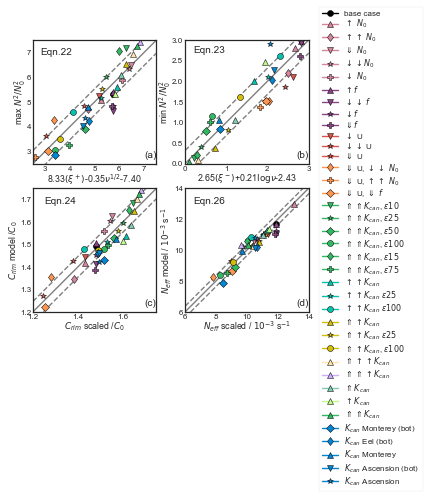

In [38]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2,wspace=0.2)
ax1 = plt.subplot(gs[0,0])
ax0 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])

t=6.5 # days

# ---- plot 1:1 line ----
ax0.plot(np.linspace(0,3,20),np.linspace(0,3,20), '-',color='0.5')
ax1.plot(np.linspace(2.5,7.5,20),np.linspace(2.5,7.5,20), '-', color='0.5')
ax2.plot(np.linspace(5, 15, 20),np.linspace(5,15, 20),'-', color='0.5')
ax3.plot(np.linspace(1.2, 1.8, 20),np.linspace(1.2, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax0    
phi_array = np.array([(rec.Nbe_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nbe)**2/(rec.N**2)  for rec in records_epsilon])
x_fit = np.linspace(0, 3, 50)
mean_sq_err = np.nanmean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(rec.Nab_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
x_fit = np.linspace(2.5,7.5, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(6,15, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.array([rec.Tr_scaled/rec.Tr0 for rec in records_epsilon])
sca_array = np.array([rec.Tr/rec.Tr0 for rec in records_epsilon])
x_fit = np.linspace(1.2,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
      
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
    plt2 = ax2.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 6,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt3 = ax3.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 6,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
ax0.set_xlim(0,3)
ax0.set_ylim(0,3)

ax1.set_xlim(2.5,7.5)
ax1.set_ylim(2.5,7.5)

ax2.set_xlim(6,14)
ax2.set_ylim(6,14)

ax3.set_xlim(1.2,1.75)
ax3.set_ylim(1.2,1.75)


ax0.set_ylabel('min $N^2/N^2_0$',labelpad=-1.5)
ax1.set_ylabel('max $N^2/N^2_0$',labelpad=-1.5)

ax0.set_xlabel(r'%1.2f$(\xi^-)$+%1.2f$\log{\nu}$%1.2f' %(reg_be.coef_[0], reg_be.coef_[1], reg_be.intercept_)
               ,labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(\xi^+)$%1.2f$\nu^{1/2}$%1.2f' %(reg_ab.coef_[0], reg_ab.coef_[1], reg_ab.intercept_)
               ,labelpad=0.5)

ax1.text(2.8,6.9,'Eqn.22')
ax0.text(0.2,2.7,'Eqn.23')
ax2.text(6.5,13.0,'Eqn.26')
ax3.text(1.25,1.68,'Eqn.24')

ax2.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax2.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)

ax3.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax3.set_xlabel(r'$C_{rim}$ scaled /$C_0$', labelpad=0.0)

ax0.legend(bbox_to_anchor=(1.05,1.3), ncol=1,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

ax1.text(0.9,0.05,'(a)',transform=ax1.transAxes)
ax0.text(0.9,0.05,'(b)',transform=ax0.transAxes)
ax3.text(0.9,0.05,'(c)',transform=ax3.transAxes)
ax2.text(0.9,0.05,'(d)',transform=ax2.transAxes)

plt.savefig('figure10_v2.eps',format='eps',bbox_inches='tight')


### Figure 10

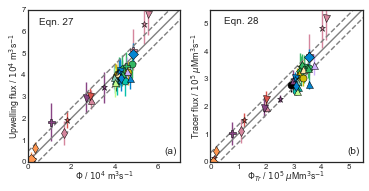

In [39]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# ---- plot 1:1 lines ----
ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'-', color='0.5')

# ---- plot errors ----
# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 7,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar((slope6*(rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*(rec.Tr_scaled))+intercept6)/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 7,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)


# ---- aesthetics ----
ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlim(0,7)
ax0.set_ylim(0,7)

ax1.set_xlim(0,5.5)
ax1.set_ylim(0,5.5)

ax0.text(0.5,6.3,'Eqn. 27')
ax1.text(0.5,5,'Eqn. 28')

ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)

plt.savefig('figure11_v2.eps',format='eps',bbox_inches='tight')


In [40]:
print ("\t".join(['Experiment &','$\kappa_{bg}$ &','$\kappa_{can}$&','$\epsilon$&',
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&$%0.2e$\t&$%0.2e$\t&$%1.0f$ ' 
                      % (rec.label2,
                         rec.kbg,
                         rec.kv, 
                         rec.epsilon,
                         )
                       ]))

Experiment &	$\kappa_{bg}$ &	$\kappa_{can}$&	$\epsilon$&
base case	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow$ $K_{bg}$	&$1.00e-04$	&$1.00e-04$	&$5$ 
$\uparrow \uparrow$ $K_{bg}$	&$1.00e-03$	&$1.00e-03$	&$5$ 
$\uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ $f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\downarrow \downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\Downarrow$ $f$	&$1.00e-05$	&$1.0

In [41]:
print ("\t".join(['Experiment &', '$N$ (s$^{-1}$)$&', 
                  '$f$ (s$^{-1}$)&', 'U (ms$^{-1}$)&', '$Bu$&', '$Ro$' ,
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&\t&$%.1e$\t&$%.2e$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t ' 
                      % (rec.label2, 
                         rec.N,
                         rec.f,
                         rec.u_mod,
                         Bu(rec.N, rec.f,Wsb,Hs),
                         Ro(U=rec.u_mod, f=rec.f, R=L),
                         )
                       ]))

Experiment &	$N$ (s$^{-1}$)$&	$f$ (s$^{-1}$)&	U (ms$^{-1}$)&	$Bu$&	$Ro$
base case	&	&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.65$	&$0.59$	 
$\uparrow$ $K_{bg}$	&	&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.65$	&$0.59$	 
$\uparrow \uparrow$ $K_{bg}$	&	&$5.5e-03$	&$9.66e-05$	&$0.32$	&$0.65$	&$0.52$	 
$\uparrow$ $N_0$	&	&$6.3e-03$	&$9.66e-05$	&$0.38$	&$0.74$	&$0.61$	 
$\uparrow \uparrow$ $N_0$	&	&$7.4e-03$	&$9.66e-05$	&$0.40$	&$0.87$	&$0.64$	 
$\Downarrow$ $N_0$	&	&$4.6e-03$	&$9.66e-05$	&$0.35$	&$0.54$	&$0.56$	 
$\downarrow \downarrow N_0$	&	&$4.7e-03$	&$9.66e-05$	&$0.35$	&$0.55$	&$0.56$	 
$\downarrow$ $N_0$	&	&$5.0e-03$	&$9.66e-05$	&$0.35$	&$0.59$	&$0.57$	 
$\uparrow f$	&	&$5.5e-03$	&$1.00e-04$	&$0.36$	&$0.62$	&$0.56$	 
$\downarrow \downarrow$ $f$	&	&$5.5e-03$	&$7.68e-05$	&$0.39$	&$0.81$	&$0.80$	 
$\downarrow f$	&	&$5.5e-03$	&$8.60e-05$	&$0.38$	&$0.73$	&$0.69$	 
$\Downarrow f$	&	&$5.5e-03$	&$6.40e-05$	&$0.41$	&$0.98$	&$1.01$	 
$\downarrow$ U	&	&$5.5e-03$	&$9.66e-05$	&$0.31$	&$0.65$	&$0.51$	 
$\downarrow

In [42]:
print ("\t".join(['Exp name&','Phi 1E4&','PhiTr 1E5&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (%)&',
                  'TotalTrMass $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMass (%) ' ]))

    
for rec,recNoC in zip(records_sel,records_selNoC):
    
    
    print ("\t".join(['%s\t&%0.2f$\pm$%0.2f\t&%0.2f$\pm$ %0.2f\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t\t&%.2f\t ' 
                      % (rec.label2,
                         rec.Phi/1E4,rec.Phi_std/1E4,
                         rec.PhiTr/1E5, rec.PhiTr_std/1E5,
                         (rec.HCW[18]-rec.HCW[0])/1E10,
                         (((rec.HCW[18]-rec.HCW[0])-(recNoC.HCW[18]-recNoC.HCW[0]))/(rec.HCW[18]-rec.HCW[0]))*100,
                         (rec.TrMass[18]-rec.TrMass[0])/1E11,
                         (((rec.TrMass[18]-rec.TrMass[0])-
                           (recNoC.TrMass[18]-recNoC.TrMass[0]))/(rec.TrMass[18]-rec.TrMass[0]))*100,
                         (rec.TrMassTot[18]-rec.TrMassTot[0])/1E11,
                         (((rec.TrMassTot[18]-rec.TrMassTot[0]-
                            recNoC.TrMassTot[18]+recNoC.TrMassTot[0]))/(rec.TrMassTot[18]-rec.TrMassTot[0]))*100)
                     ]))
    

Exp name&	Phi 1E4&	PhiTr 1E5&	Total HCW $10^{10}$ m$^3$&	CanyonHCW (%)&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW (%)&	TotalTrMass $10^{11}$ $\mu$Mm$^3$&	CanyonTrMass (%) 
base case	&3.85$\pm$0.60	&2.76$\pm$ 0.26	&2.83	&82.32		&2.19		&83.24	&1.93		&16.43	 
$\uparrow$ $K_{bg}$	&3.70$\pm$0.73	&2.29$\pm$ 0.24	&2.78	&88.03		&2.03		&87.96	&1.95		&16.70	 
$\uparrow \uparrow$ $K_{bg}$	&3.72$\pm$1.58	&0.96$\pm$ 0.40	&3.09	&64.28		&1.77		&59.27	&2.22		&17.07	 
$\uparrow$ $N_0$	&2.86$\pm$0.44	&1.99$\pm$ 0.19	&2.06	&89.34		&1.55		&89.53	&1.64		&11.93	 
$\uparrow \uparrow$ $N_0$	&1.32$\pm$0.55	&1.11$\pm$ 0.44	&1.08	&79.51		&0.80		&79.64	&1.35		&7.43	 
$\Downarrow$ $N_0$	&6.78$\pm$0.94	&5.21$\pm$ 0.82	&4.60	&29.18		&3.67		&35.01	&2.42		&23.23	 
$\downarrow \downarrow N_0$	&6.34$\pm$0.92	&4.84$\pm$ 0.72	&4.33	&31.01		&3.44		&36.55	&2.35		&22.33	 
$\downarrow$ $N_0$	&5.15$\pm$0.95	&3.86$\pm$ 0.74	&3.67	&35.74		&2.89		&40.58	&2.18		&20.13	 
$\uparrow f$	&4.03$\pm$0.58	&2.95$\pm$ 0.36	&2.94	&

In [43]:
rec.name

'3DVISC_REALISTIC_run27'